# On the Voigt profile

Here, we use a differentiable Voigt profile to examine its properties.

In [4]:
from exojax.opacity.lpf.lpf import voigt
import jax.numpy as jnp
import matplotlib.pyplot as plt

Let's compute the Voigt function $V(\nu, \beta, \gamma_L)$ using ExoJAX!
$V(\nu, \beta, \gamma_L)$ is a convolution of a Gaussian with a STD of $\beta$ and a Lorentian with a gamma parameter of $\gamma_L$. 


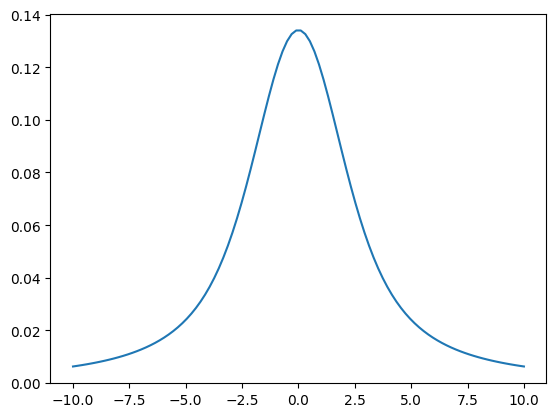

In [5]:
nu=jnp.linspace(-10,10,100)

plt.plot(nu, voigt(nu,1.0,2.0)) #beta=1.0, gamma_L=2.0

The function `spec.lpf.voigt` is [vmapped](https://docs.jax.dev/en/latest/automatic-vectorization.html#id2) for the wavenumber (`nu`) as input=0, therefore a bit hard to handle when you want to differentiate. Instead, you can use `spec.lpf.voigtone`, which is not vmapped for all of the input arguments. 


In [6]:
from exojax.opacity.lpf.lpf import voigtone
from jax import grad, vmap

dvoigt_nu = vmap(grad(voigtone, argnums=0), (0, None, None), 0)  # derivative by nu
dvoigt_beta = vmap(grad(voigtone, argnums=1), (0, None, None), 0)  # derivative by beta

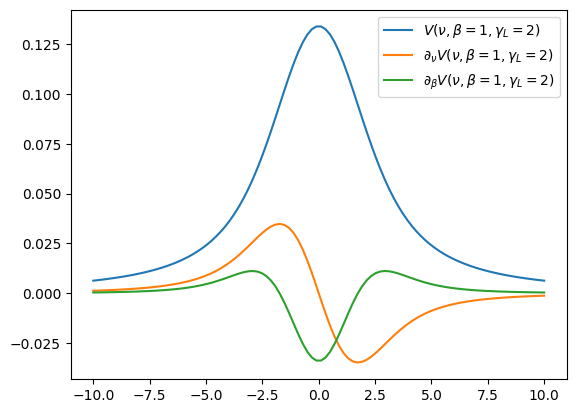

In [7]:
plt.plot(nu, voigt(nu,1.0,2.0),label="$V(\\nu,\\beta=1,\\gamma_L=2)$")
plt.plot(nu, dvoigt_nu(nu,1.0,2.0),label="$\\partial_\\nu V(\\nu,\\beta=1,\\gamma_L=2)$")
plt.plot(nu, dvoigt_beta(nu,1.0,2.0),label="$\\partial_\\beta V(\\nu,\\beta=1,\\gamma_L=2)$")
plt.legend()

## HMC-NUTS of a simple absorption model

Next, we try to fit a simple absorption model to mock data.
The absorption model is 

$ e^{-a V(\nu,\beta,\gamma_L)}$


In [10]:
def absmodel(nu,a,beta,gamma_L):
    return jnp.exp(-a*voigt(nu,beta,gamma_L))

Adding a noise...


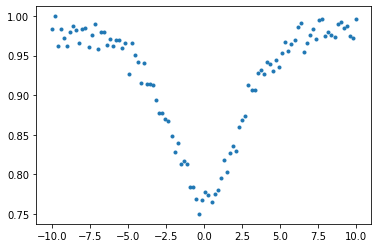

In [11]:
from numpy.random import normal
data=absmodel(nu,2.0,1.0,2.0)+normal(0.0,0.01,len(nu))
plt.plot(nu,data,".")

Then, let's perfomr a HMC-NUTS.

In [12]:
import arviz
import numpyro.distributions as dist
import numpyro
from numpyro.infer import MCMC, NUTS
from numpyro.infer import Predictive
from numpyro.diagnostics import hpdi

In [13]:
def model_c(nu,y):
    sigma = numpyro.sample('sigma', dist.Exponential(1.0))
    a = numpyro.sample('a', dist.Exponential(1.0))
    beta = numpyro.sample('beta', dist.Exponential(1.0))
    gamma_L = numpyro.sample('gammaL', dist.Exponential(1.0))
    mu=absmodel(nu,a,beta,gamma_L)
    numpyro.sample('y', dist.Normal(mu, sigma), obs=y)

In [14]:
from jax import random
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
num_warmup, num_samples = 1000, 2000

In [15]:
kernel = NUTS(model_c,forward_mode_differentiation=True)
mcmc = MCMC(kernel, num_warmup, num_samples)
mcmc.run(rng_key_, nu=nu, y=data)

sample: 100%|██████████| 3000/3000 [00:48<00:00, 65.47it/s, 15 steps of size 1.93e-01. acc. prob=0.95]


In [16]:

posterior_sample = mcmc.get_samples()
pred = Predictive(model_c,posterior_sample)
predictions = pred(rng_key_,nu=nu,y=None)
                                                                                    
median_mu = jnp.median(predictions["y"],axis=0)
hpdi_mu = hpdi(predictions["y"], 0.9)

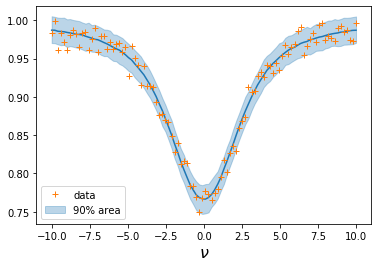

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=1)                                                 
ax.plot(nu,median_mu,color="C0")
ax.plot(nu,data,"+",color="C1",label="data")
ax.fill_between(nu, hpdi_mu[0], hpdi_mu[1], alpha=0.3, interpolate=True,color="C0",
                label="90% area")
plt.xlabel("$\\nu$",fontsize=16)
plt.legend()


We got a posterior sampling.

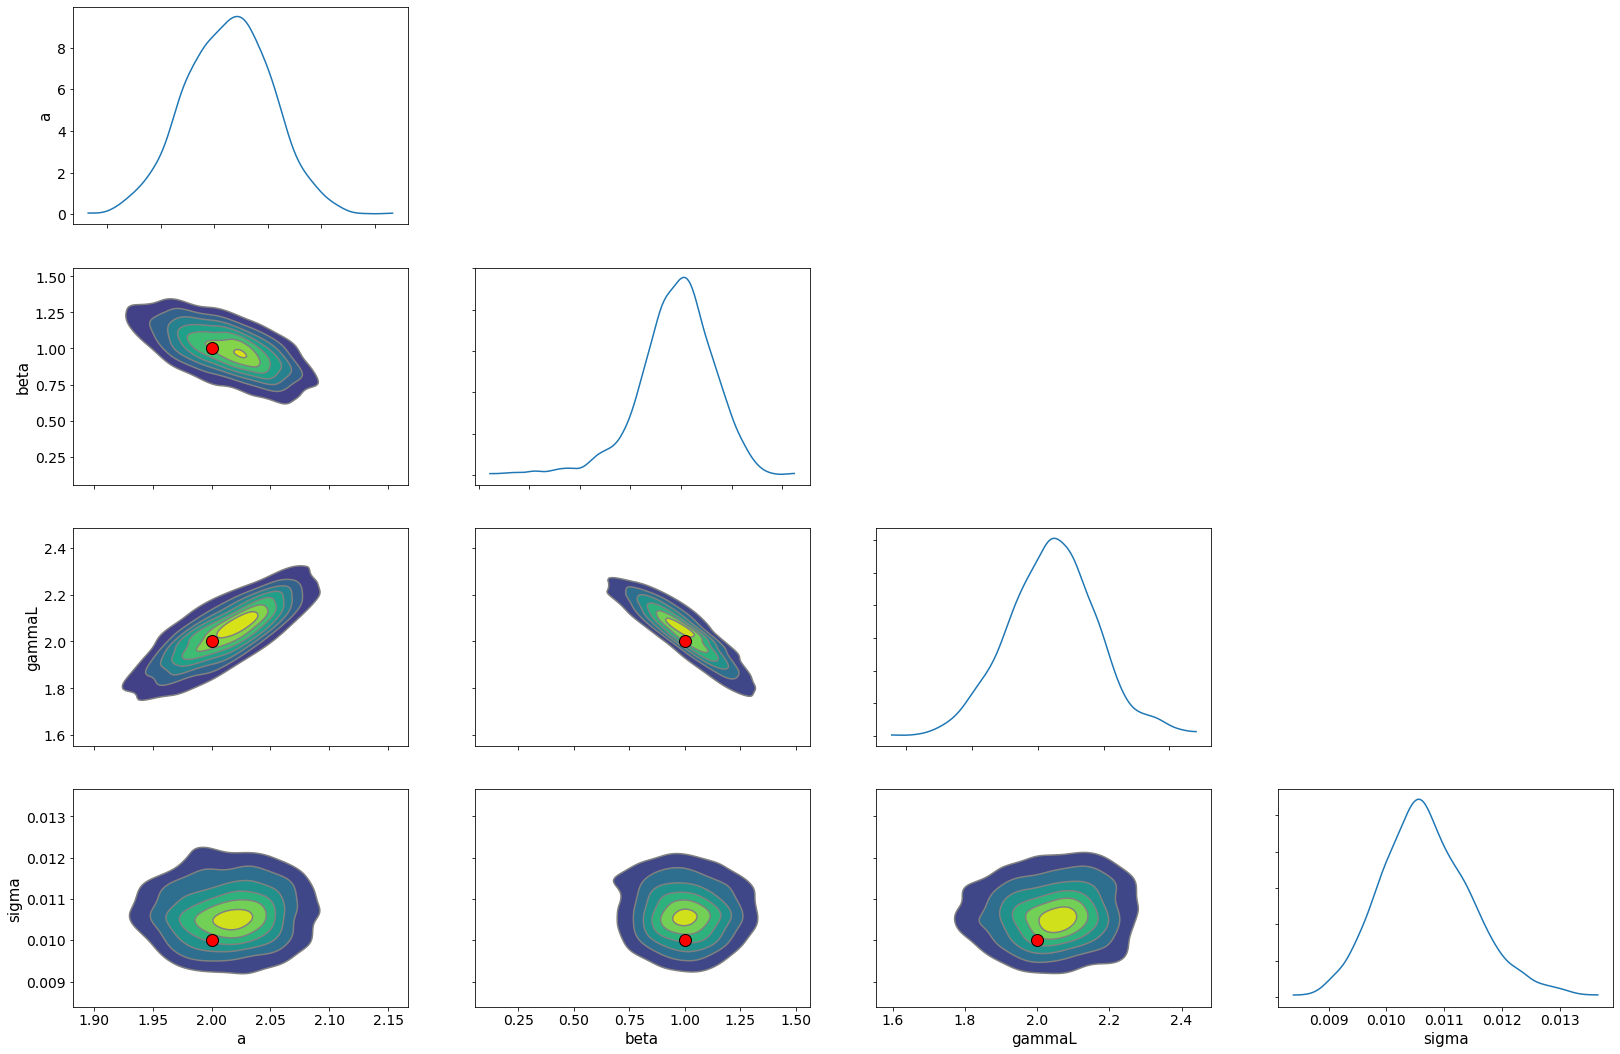

In [18]:
refs={};refs["sigma"]=0.01;refs["a"]=2.0;refs["beta"]=1.0;refs["gammaL"]=2.0
arviz.plot_pair(arviz.from_numpyro(mcmc),kind='kde',\
                divergences=False,marginals=True,reference_values=refs,\
               reference_values_kwargs={'color':"red", "marker":"o", "markersize":12})
plt.show()

## Curve of Growth

As an application, we consider the curve of growth.
The curve of growth is the equivalent width evolution as a function of the absorption sterngth. Here, it corresponds to $a$. Let's see, the growth of absorption feature as

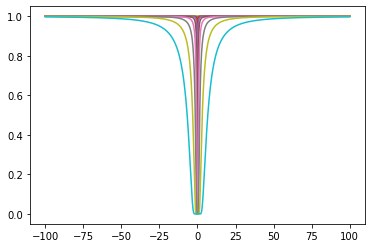

In [116]:
nu=jnp.linspace(-100,100,10000)
aarr=jnp.logspace(-3,3,10)
for a in aarr:
    plt.plot(nu,absmodel(nu,a,0.1,0.1))

Let us define the equivalent width by a simple summation of the absorption.

In [109]:
def EW(a):
    return jnp.sum(1-absmodel(nu,a,0.1,0.1))
vEW=vmap(EW,0,0)

This is the curve of growth. As you see, when the absorption is weak, the power of the curve is proportional to unity (linear region). But, as increasing the absorption sterength, the power converges to 1/2.  

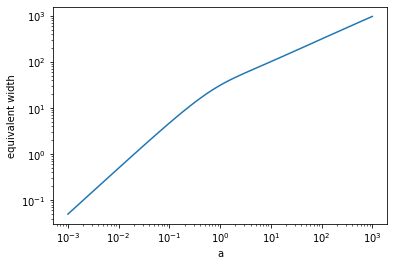

In [119]:
aarr=jnp.logspace(-3,3,100)
plt.plot(aarr,vEW(aarr))
plt.yscale("log")
plt.xscale("log")
plt.xlabel("a")
plt.ylabel("equivalent width")
plt.show()

Now we have the auto-diff for the Voigt function. So, we can directly compute the power as a function of $a$.

$power = \frac{\partial}{\partial \log_{10} a } \log_{10} ( EW ) $

In [120]:
def logEW(loga):
    return jnp.log10(jnp.sum(1-absmodel(nu,10**(loga),0.1,0.1)))

In [121]:
dlogEW=grad(logEW)
vlogdEW=vmap(dlogEW,0,0)

In this way, the curve of growth can be directly calculated.

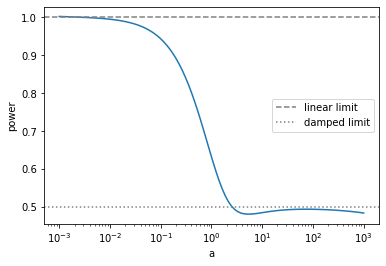

In [122]:
logaarr=jnp.linspace(-3,3,100)
plt.plot(10**(logaarr),vlogdEW(logaarr))
plt.axhline(1.0,label="linear limit",color="gray",ls="dashed")
plt.axhline(0.5,label="damped limit",color="gray",ls="dotted")
plt.xscale("log")
plt.xlabel("a")
plt.ylabel("power")
plt.legend()
plt.show()

That's it